# Common_Task_02

# quark/gluon Classification

In [1]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch.optim import Adam
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.nn import Linear

In [3]:
# Check if CUDA (GPU) is available; otherwise, default to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/kaggle/input/autoencoder-data/quark-gluon_data-set_n139306.hdf5"

In [4]:
print(device)

cuda


In [5]:
def explore_hdf5(file):
    with h5py.File(file, "r") as f:
        print("Keys in dataset:", list(f.keys()))
        for key in f.keys():
            print(f"Shape of {key}: {f[key].shape}")

explore_hdf5(file_path)

Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Shape of X_jets: (139306, 125, 125, 3)
Shape of m0: (139306,)
Shape of pt: (139306,)
Shape of y: (139306,)


In [6]:
def load_data(file_name, sample_size):
    with h5py.File(file_name, 'r') as f:
        print("Dataset keys:", list(f.keys()))
        print("Total images:", len(f['X_jets']))
        print("Image dimensions:", f['X_jets'].shape[1:])
        return np.array(f['X_jets'][:sample_size]), np.array(f['y'][:sample_size])

# Load 10,000 samples from the dataset
X, y = load_data(file_path, 10000)

Dataset keys: ['X_jets', 'm0', 'pt', 'y']
Total images: 139306
Image dimensions: (125, 125, 3)


In [7]:
def count_labels(labels):
    label_counts = np.bincount(labels.astype(np.int64))
    return {str(i): count for i, count in enumerate(label_counts)}

print(count_labels(y))


{'0': 4994, '1': 5006}


In [8]:
def preprocess_images(images):
    from skimage.transform import resize
    # Resize to 128x128 and normalize
    processed = np.array([resize(img, (128, 128), anti_aliasing=True) for img in images], dtype=np.float32)
    # Compute mean and standard deviation for normalization
    mean, std = np.mean(processed), np.std(processed)
    # Normalize: (X - mean) / std, and clip negative values to 0
    return np.clip((processed - mean) / std, 0, None)

X = preprocess_images(X)


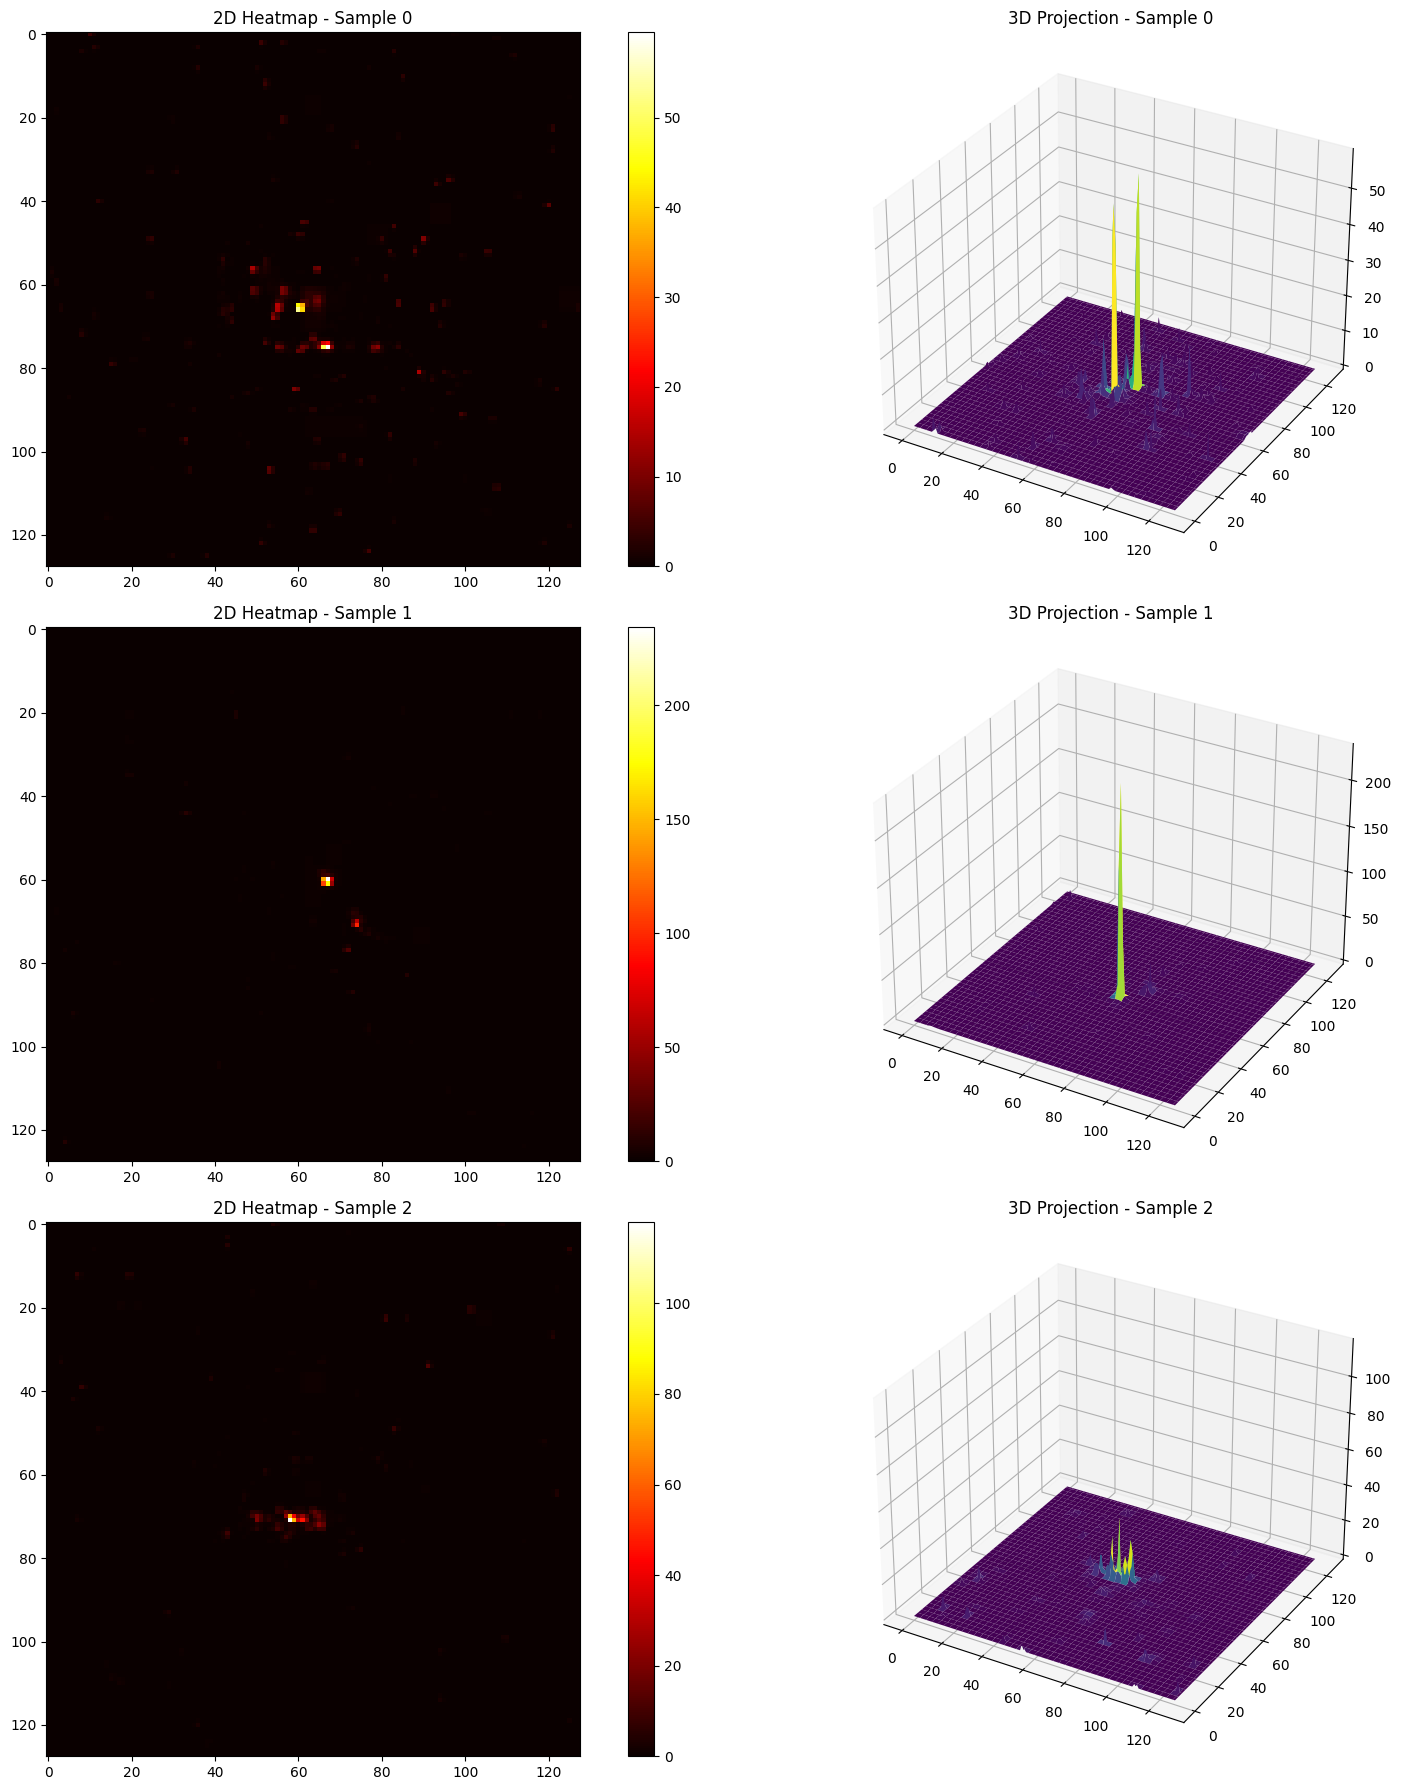

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def heatmap_with_projection(images, num_samples=3):
    fig = plt.figure(figsize=(18, 6 * num_samples))
    
    for idx in range(num_samples):
        # 2D Heatmap
        ax1 = fig.add_subplot(num_samples, 2, 2*idx + 1)
        combined_data = np.sum(images[idx], axis=-1)
        heatmap = ax1.imshow(combined_data, cmap='hot', interpolation='nearest')
        plt.colorbar(heatmap, ax=ax1)
        ax1.set_title(f'2D Heatmap - Sample {idx}')
        
        # 3D Projection
        ax2 = fig.add_subplot(num_samples, 2, 2*idx + 2, projection='3d')
        X, Y = np.meshgrid(np.arange(combined_data.shape[1]), np.arange(combined_data.shape[0]))
        ax2.plot_surface(X, Y, combined_data, cmap='viridis')
        ax2.set_title(f'3D Projection - Sample {idx}')
    
    plt.tight_layout()
    plt.show()

heatmap_with_projection(X)


In [10]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_3d_rotation(images, sample_idx=0):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    combined_data = np.sum(images[sample_idx], axis=-1)
    X, Y = np.meshgrid(np.arange(combined_data.shape[1]), np.arange(combined_data.shape[0]))
    surf = ax.plot_surface(X, Y, combined_data, cmap='viridis')
    
    def update(frame):
        ax.view_init(elev=20, azim=frame)
        return fig,
    
    anim = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
    plt.close()
    return HTML(anim.to_html5_video())

animate_3d_rotation(X, sample_idx=0)

In [11]:
def extract_nonzero_mask(images):
    # Reshape the images array to combine height and width dimensions while keeping the 3 channels (Track, ECAL, HCAL)
    reshaped = images.reshape((-1, images.shape[1] * images.shape[2], 3))
    # Check if any channel in each pixel has nonzero values (i.e., meaningful data) and create a binary mask
    # axis=-1 ensures the check is applied along the 3 channels (Track, ECAL, HCAL)
    return np.any(reshaped != [0., 0., 0.], axis=-1).reshape(images.shape[:3])# Restore the original shape

mask = extract_nonzero_mask(X)

In [12]:
def create_graph_features(masked_data):
    indices, features = [], [] # Initialize lists to store the indices (coordinates) and features (pixel values)
    # Iterate through each image and its corresponding mask
    for img_idx, mask in enumerate(masked_data):
        # Get the coordinates (row, column) of non-zero pixels (True pixels in the mask)
        coords = np.column_stack(np.where(mask))

        # Extract the feature (pixel values) for the corresponding coordinates in the image
        # `coords[:, 0]` gives the row indices, and `coords[:, 1]` gives the column indices
        features.append(X[img_idx, coords[:, 0], coords[:, 1], :])# Collect feature values (Track, ECAL, HCAL)
        # Store the coordinates of the non-zero pixels as graph nodes
        indices.append(coords)

    return indices, features

indices_list, features_list = create_graph_features(mask)

In [13]:
def build_graph_structure(coords, k=4):
    from scipy.spatial import cKDTree
    from scipy.sparse import coo_matrix
    # Create a k-d tree from the coordinates to efficiently find the k nearest neighbors
    tree = cKDTree(coords)

    # Query the k nearest neighbors for each point (coordinates)
    # dist contains the distances to the k nearest neighbors, indices contains their indices
    dist, indices = tree.query(coords, k=k)

    # Compute the variance of the distance of the k-th nearest neighbor (to use as a scaling factor for the kernel)
    sigma2 = np.mean(dist[:, -1])**2

    # Compute the weights for the edges based on the Gaussian kernel (exponent of negative squared distance / sigma^2)
    weights = np.exp(-dist**2 / sigma2)

    # Create the row and column indices for the sparse adjacency matrix
    # Repeat the index for each neighbor and flatten the indices array for the coo_matrix
    row, col = np.arange(len(coords)).repeat(k), indices.flatten()

    # Return the sparse adjacency matrix in COO format
    return coo_matrix((weights.flatten(), (row, col)), shape=(len(coords), len(coords)))


In [14]:
def create_graph_dataset(indices_list, labels, neighbors=8):
    dataset = []
    # Loop over each sample in the indices list
    for i, points in enumerate(indices_list):
        # Build the graph structure using k-nearest neighbors (k=neighbors)
        adjacency = build_graph_structure(points, k=neighbors)

        # Convert the adjacency matrix row and column indices to a PyTorch tensor
        # These represent the edges of the graph
        edge_idx = torch.from_numpy(np.vstack((adjacency.row, adjacency.col))).long()

        # Convert the edge weights to a PyTorch tensor
        edge_weights = torch.from_numpy(adjacency.data).float().view(-1, 1)

        # Convert the label for the current graph to a PyTorch tensor
        label = torch.tensor([int(labels[i])], dtype=torch.long)

        # Create a PyTorch Geometric graph object containing:
        # - x: Node features (features corresponding to each point in the graph)
        # - edge_index: The indices of the edges (which nodes are connected)
        # - edge_attr: The weights of the edges
        # - y: The label of the graph
        graph = Data(x=torch.from_numpy(features_list[i]), edge_index=edge_idx, edge_attr=edge_weights, y=label)
        # Add the created graph object to the dataset
        dataset.append(graph)
    return dataset

In [15]:
# Create the graph dataset by calling the create_graph_dataset function
# The function takes in:
# - indices_list: List of indices representing the coordinates of the non-zero points in the images
# - y: The labels corresponding to each image in the dataset
# - neighbors: The number of nearest neighbors (k) to consider when building the graph structure (set to 8)
graph_dataset = create_graph_dataset(indices_list, y, neighbors=8)

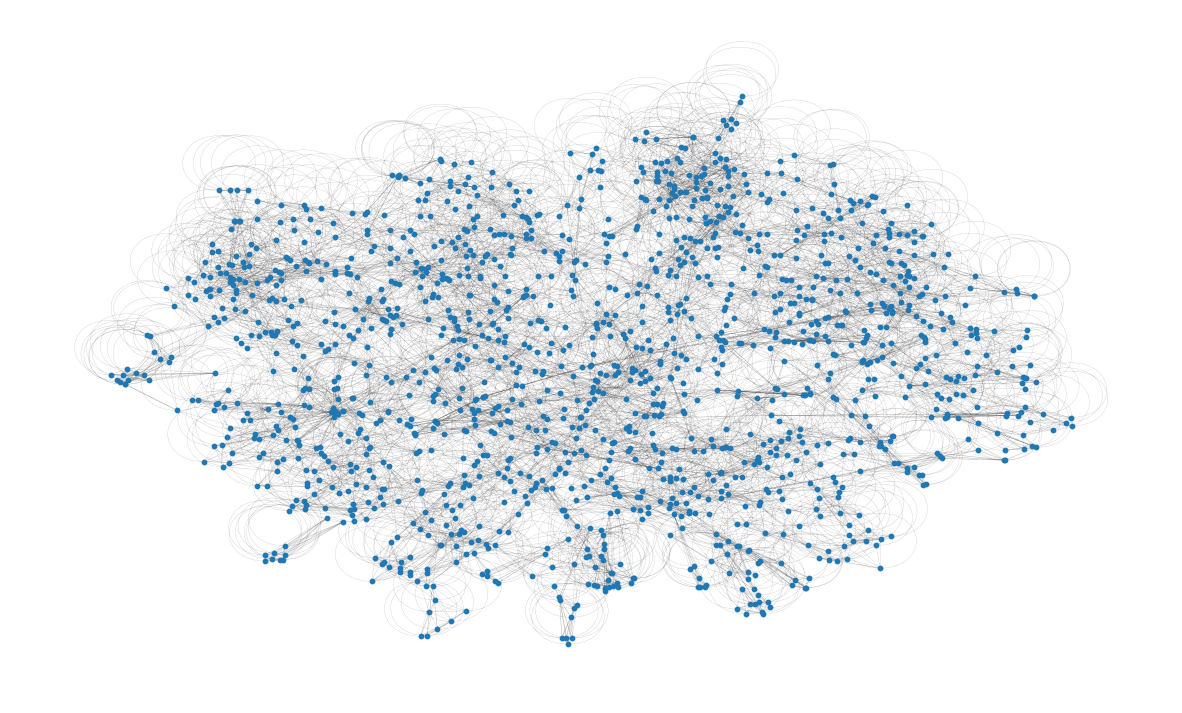

Number of graphs to work upon : 10000
For the FIRST graph in the graph dataset : 
Type of each graph entity data object: <class 'torch_geometric.data.data.Data'>
Number of nodes: 1530
Number of edges: 12240
Number of node features: 3
Number of edges features: 1


In [16]:
# Initialize an empty NetworkX graph
G = nx.Graph()

# Extract the first graph from the graph dataset
data = graph_dataset[0]

# Get the edge index tensor from the data object, which contains information about the graph edges
edge_tensor = data.edge_index

# Convert the edge index tensor into a list of edge tuples (node1, node2) for NetworkX
edge_list = [(edge_tensor[0, i].item(), edge_tensor[1, i].item()) for i in range(edge_tensor.shape[1])]

# Add the edges to the NetworkX graph G
G.add_edges_from(edge_list)

# Create a layout for the nodes of the graph using the spring layout (force-directed layout)
pos = nx.spring_layout(G, iterations=15, seed=1721)

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, node_size=10, with_labels=False, width=0.05)
plt.show()

# Print the number of graphs in the graph dataset
print(f'Number of graphs to work upon : {len(graph_dataset)}')

# Print information about the first graph in the graph dataset
print(f'For the FIRST graph in the graph dataset : ')
print(f'Type of each graph entity data object: {type(data)}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edges features: {data.num_edge_features}')

In [17]:
# Split the graph dataset into training (80%), validation (10%), and testing (10%) sets
train_data, test_data = train_test_split(graph_dataset, test_size=0.2, random_state=14)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=14)

# Create DataLoader instances for the train, validation, and test sets with batch size of 128
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

In [18]:
from torch_geometric.nn import SAGEConv,global_mean_pool
class GNN(torch.nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes):
        super().__init__()

         # Defining the layers of the GCN
        # First GraphSAGE layer transforms input features to hidden_dim
        self.layers = nn.ModuleList([
            SAGEConv(in_features, hidden_dim),
            SAGEConv(hidden_dim, 2 * hidden_dim),
            SAGEConv(2 * hidden_dim, hidden_dim)
        ])

        # Fully connected layers to map the hidden feature vector to the output classes
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, edge_index, batch):
         # Apply each GCN layer followed by ReLU activation
        for layer in self.layers:
            x = F.relu(layer(x, edge_index))

        # Global mean pooling to aggregate node-level features to graph-level features
        x = global_mean_pool(x, batch)# Pooling the node features for graph classification

        # Pass the pooled graph-level features through the fully connected layers
        return self.linear(x)# Return the output from the linear layers (final classification)

In [19]:
def train(model, loader, optimizer, criterion):
    """
    Function to train the model for one epoch.
    Arguments:
        model: The neural network model to train.
        loader: DataLoader instance containing the training dataset.
        optimizer: The optimizer to update the model's weights.
        criterion: The loss function used to compute the error.
    Returns:
        total_loss: Total loss accumulated over all batches in the epoch.
    """
    model.train()
    total_loss = 0
    num_batches = 0
    # Iterate through batches in the DataLoader
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        # Forward pass: Compute predicted outputs by passing the data through the model
        loss = criterion(model(data.x, data.edge_index, data.batch), data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss

def evaluate(model, loader):
    """
    Function to evaluate the model's performance.
    Arguments:
        model: The trained model to evaluate.
        loader: DataLoader instance containing the validation or test dataset.
    Returns:
        accuracy: The model's accuracy on the given dataset.
    """
    model.eval()
    correct = 0
    # Iterate through batches in the DataLoader
    for data in loader:
        data = data.to(device)
        # Forward pass: Compute predictions and find the class with the highest probability
        pred = model(data.x, data.edge_index, data.batch).argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

# Model initialization: Input features = 3, hidden dim = 64, number of output classes = 2
model = GNN(3, 64, 2).to(device)
# Optimizer: Adam with learning rate of 0.001
optimizer = Adam(model.parameters(), lr=0.001)
# Loss function: CrossEntropyLoss for classification tasks
criterion = nn.CrossEntropyLoss()


In [20]:
def compute_roc_auc(model, loader):
    """
    Function to compute ROC AUC score for the model on a given data loader.
    Arguments:
        model: The trained model.
        loader: DataLoader instance containing the validation or test dataset.
    Returns:
        auc_score: The AUC score for the model.
        fpr: False Positive Rate values for ROC curve.
        tpr: True Positive Rate values for ROC curve.
    """
    model.eval()
    y_true, y_scores = [], []
    # Iterate through batches in the DataLoader
    for data in loader:
        data = data.to(device)
        outputs = model(data.x, data.edge_index, data.batch)
        probs = F.softmax(outputs, dim=1)[:, 1].cpu().detach().numpy()
        y_true.extend(data.y.cpu().numpy())
        y_scores.extend(probs)

    # Compute the ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return auc(fpr, tpr), fpr, tpr # Return the AUC score, and the FPR and TPR for plotting

train_losses = []  
train_accuracies = []
test_accuracies = []
roc_auc_scores = []
best_test_acc = 0  

# Training loop for 40 epochs
for epoch in range(40):
    train_loss = train(model, train_loader, optimizer, criterion)  
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    roc_auc, fpr, tpr = compute_roc_auc(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    roc_auc_scores.append(roc_auc)

    # Update best test accuracy
    if test_acc > best_test_acc:
        best_test_acc = test_acc

    # Print metrics for the current epoch
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, ROC AUC: {roc_auc:.4f}')


# After the loop, print the best test accuracy obtained during training
print(f'\nBest Test Accuracy: {best_test_acc:.4f}')
    

Epoch 0, Train Loss: 37.8411, Train Acc: 0.6118, Test Acc: 0.6160, ROC AUC: 0.7305
Epoch 1, Train Loss: 34.9619, Train Acc: 0.6907, Test Acc: 0.6820, ROC AUC: 0.7538
Epoch 2, Train Loss: 34.4368, Train Acc: 0.6917, Test Acc: 0.6950, ROC AUC: 0.7590
Epoch 3, Train Loss: 33.9946, Train Acc: 0.6978, Test Acc: 0.7000, ROC AUC: 0.7634
Epoch 4, Train Loss: 34.0930, Train Acc: 0.6976, Test Acc: 0.6920, ROC AUC: 0.7647
Epoch 5, Train Loss: 33.5990, Train Acc: 0.7039, Test Acc: 0.7045, ROC AUC: 0.7695
Epoch 6, Train Loss: 33.4563, Train Acc: 0.7069, Test Acc: 0.7095, ROC AUC: 0.7709
Epoch 7, Train Loss: 33.7253, Train Acc: 0.7061, Test Acc: 0.7060, ROC AUC: 0.7720
Epoch 8, Train Loss: 33.3427, Train Acc: 0.7113, Test Acc: 0.7105, ROC AUC: 0.7731
Epoch 9, Train Loss: 33.0761, Train Acc: 0.7107, Test Acc: 0.7165, ROC AUC: 0.7762
Epoch 10, Train Loss: 33.3491, Train Acc: 0.7087, Test Acc: 0.7085, ROC AUC: 0.7733
Epoch 11, Train Loss: 33.2569, Train Acc: 0.6908, Test Acc: 0.6905, ROC AUC: 0.7761
Ep

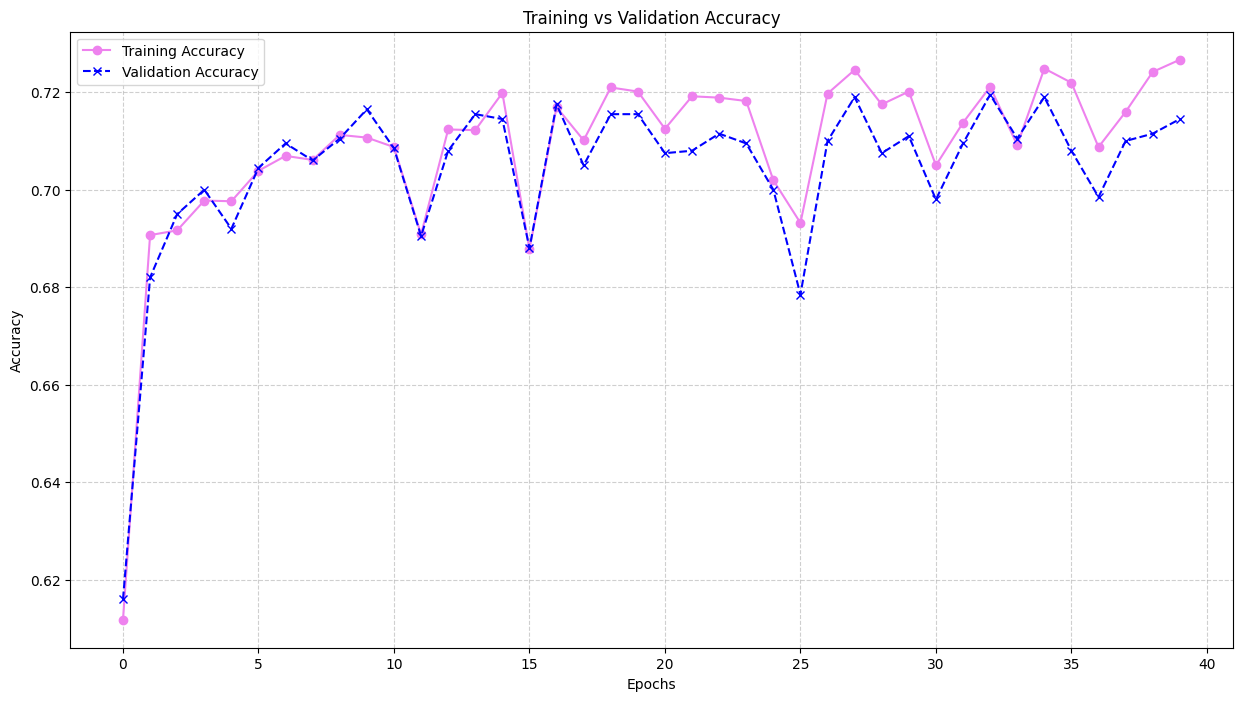

In [21]:
# Plotting the Training and Validation Accuracy over the epochs
plt.figure(figsize=(15, 8))
plt.plot(train_accuracies, marker='o', linestyle='-', label='Training Accuracy', color='violet')
plt.plot(test_accuracies, marker='x', linestyle='--', label='Validation Accuracy', color='blue')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

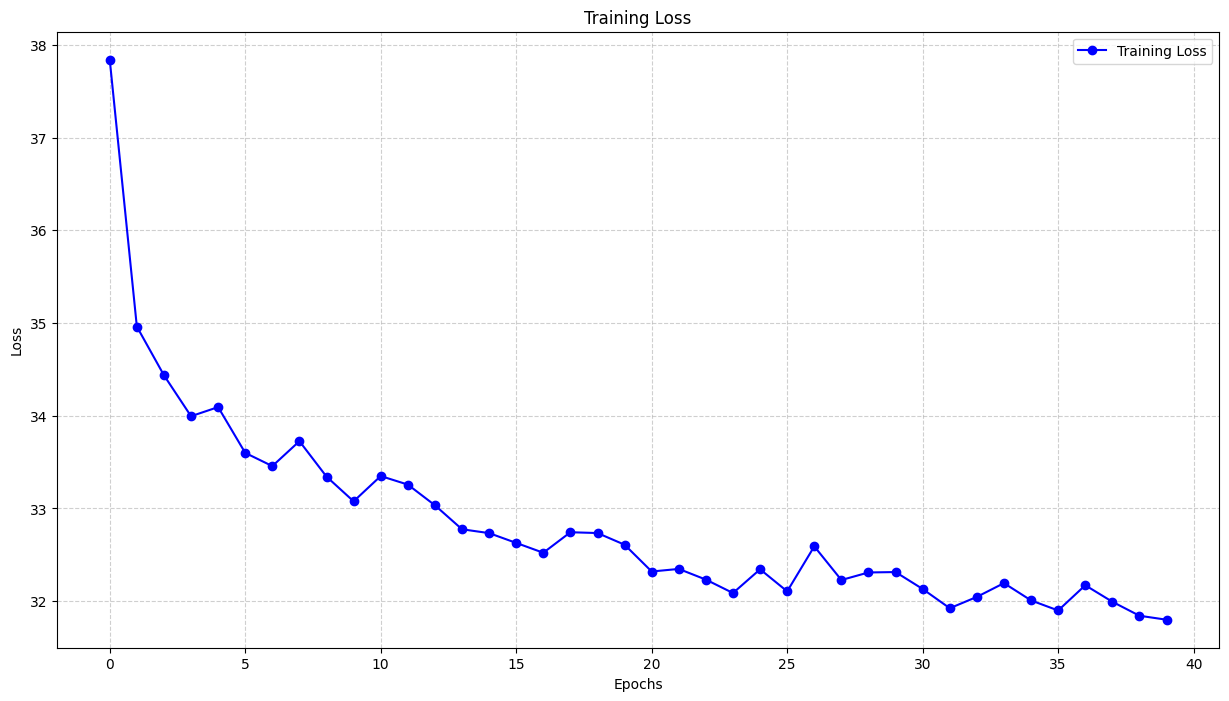

In [22]:
# Plotting the Training Loss over the epochs
plt.figure(figsize=(15, 8))
plt.plot(train_losses, marker='o', linestyle='-', label='Training Loss', color='blue')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

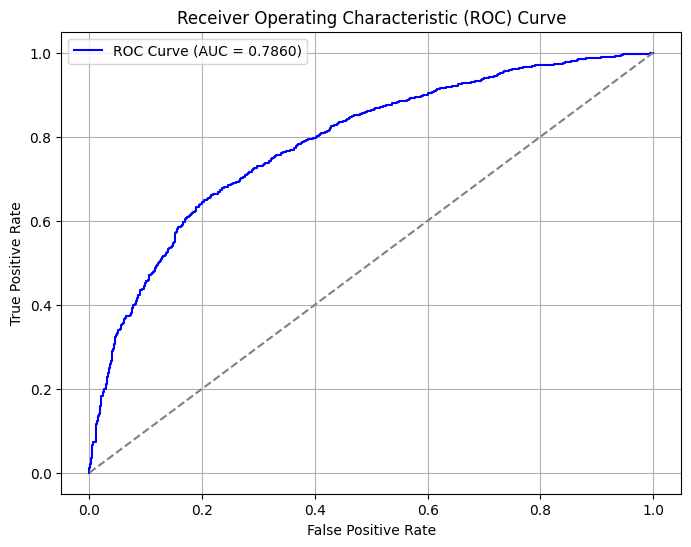

In [23]:
# Compute ROC AUC and False Positive Rate (FPR), True Positive Rate (TPR)
roc_auc, fpr, tpr = compute_roc_auc(model, test_loader)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()